In [2]:
import glob
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from itertools import combinations

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten, Lambda



2022-02-10 11:41:54.968094: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# Load Data

In [3]:
# load data from path


poses = []
labels = []
data_labels = ("A", "T", "W", "X", "Y")

for c, char in enumerate(data_labels):
    with open(f'../dataset/{char}.pickle', 'rb') as f:
        data = np.load(f, allow_pickle=True)['data']

        for pose in data:
            poses.append(np.array(pose))
            labels.append(c)

print("data shape:", np.array(poses).shape)

data shape: (363, 12, 2)


In [84]:
def shift_pose(pose):
    # left foot joint
    return pose - pose[-1]

def scale_pose(pose):
    lenX = .5
    lenY = .5
    rHip = pose[7]
    lShoulder = pose[0]
    y, x = lShoulder - rHip
    rX, rY = abs(lenX/x), abs(lenY/y)
    scaled_pose =pose.copy()
    scaled_pose[:, 1] = pose[:, 1] * rX
    scaled_pose[:, 0] = pose[:, 0] * rY
    return scaled_pose

def preprocessing(pose):
    """
        apply pose shift and scalling
    """
    pose = shift_pose(pose)
    return scale_pose(pose)

data shape: (65703, 48)


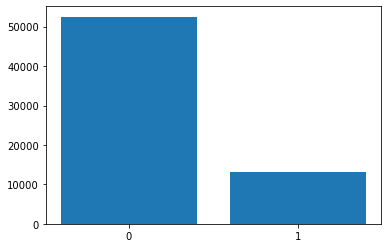

In [5]:

N = labels.__len__()

X = []
y = []

for (idx0, idx1) in combinations(range(N), 2):
    sample1 = preprocessing(poses[idx0])
    sample2 = preprocessing(poses[idx1])

    X.append(np.concatenate([sample1, sample2]).flatten())
    y.append(int(labels[idx0] == labels[idx1]))

X = np.array(X)
y = np.array(y)

print("data shape:", X.shape)

zeros = y[y==0].__len__()
ones = y[y==1].__len__()
plt.bar(["0", "1"], [zeros, ones]);

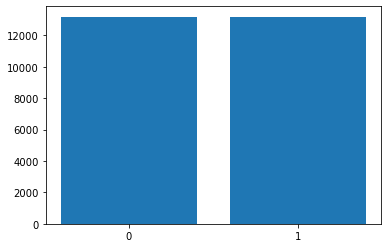

In [6]:
# downsample
trues = X[y == 1]
falses = X[y == 0]
small_falses = resample(falses, n_samples=trues.shape[0])

balanced_X = np.concatenate([trues, small_falses])
balanced_y = np.concatenate([np.ones((trues.shape[0],)), np.zeros((trues.shape[0]))])

trues = balanced_y[balanced_y == 1]
falses = balanced_y[balanced_y == 0]

plt.bar(["0", "1"], [trues.__len__(), falses.__len__()]);


is it same pose:  True


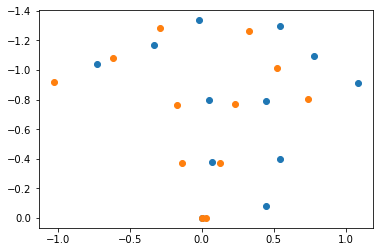

In [10]:
idx = 1000
sample = balanced_X[idx]
vec1 = sample[0:24].reshape(12, 2)
vec2 = sample[24:48].reshape(12, 2)


plt.scatter(vec1[:, 0], vec1[:, 1])
plt.scatter(vec2[:, 0], vec2[:, 1]).axes.invert_yaxis()

print("is it same pose: ", balanced_y[idx] == 1)

In [14]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [75]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(balanced_X, balanced_y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=balanced_y)

# Define network
model = Sequential([
    Dense(128, input_shape=(24 * 2, ), activation="relu"),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid"),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 128)               6272      
_________________________________________________________________
dense_37 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 65        
Total params: 14,593
Trainable params: 14,593
Non-trainable params: 0
_________________________________________________________________


In [76]:
csv_logger = CSVLogger("model_history_log.csv",)
history = model.fit(
    X_train,
    y_train,
    epochs=60,
    shuffle=True,
    batch_size=32,
    validation_split=0.30,
    callbacks=[csv_logger])

Epoch 1/60
433/433 [==============================] - 1s 2ms/step - loss: 0.3190 - accuracy: 0.8774 - val_loss: 0.1455 - val_accuracy: 0.9390
Epoch 2/60
433/433 [==============================] - 1s 1ms/step - loss: 0.1005 - accuracy: 0.9681 - val_loss: 0.0779 - val_accuracy: 0.9789
Epoch 3/60
433/433 [==============================] - 1s 1ms/step - loss: 0.0618 - accuracy: 0.9799 - val_loss: 0.0357 - val_accuracy: 0.9922
Epoch 4/60
433/433 [==============================] - 1s 1ms/step - loss: 0.0427 - accuracy: 0.9864 - val_loss: 0.0756 - val_accuracy: 0.9651
Epoch 5/60
433/433 [==============================] - 1s 1ms/step - loss: 0.0300 - accuracy: 0.9908 - val_loss: 0.0372 - val_accuracy: 0.9863
Epoch 6/60
433/433 [==============================] - 1s 1ms/step - loss: 0.0270 - accuracy: 0.9918 - val_loss: 0.0209 - val_accuracy: 0.9929
Epoch 7/60
433/433 [==============================] - 1s 1ms/step - loss: 0.0253 - accuracy: 0.9905 - val_loss: 0.0171 - val_accuracy: 0.9961
Epoch 

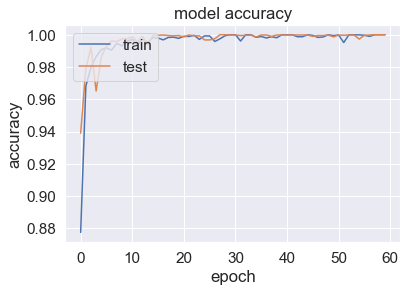

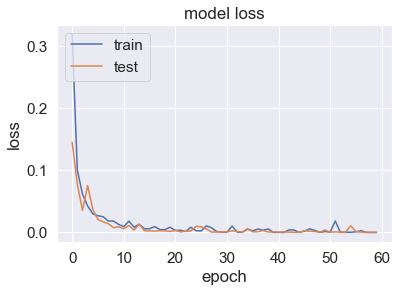

In [77]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [78]:
model.evaluate(X_test, y_test)

206/206 [==============================] - 0s 755us/step - loss: 2.4652e-04 - accuracy: 1.0000


[0.0002465189027134329, 1.0]

AUC: 1.000


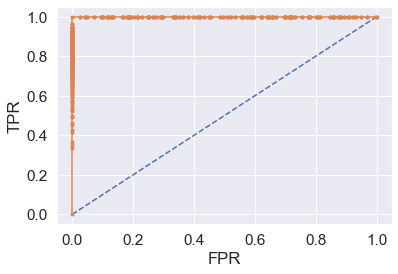

In [79]:
# Test
y_pred = model.predict(X_test).flatten()

# Check ROC, AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc)

# Plot
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

<AxesSubplot:>

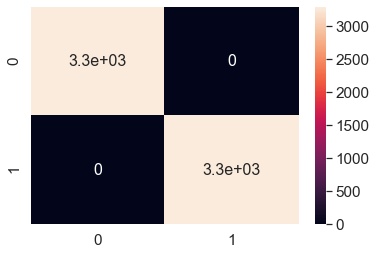

In [81]:
# y_true = list(map(np.argmax, y_test))
y_pred = model.predict_classes(X_test).flatten();

cm = confusion_matrix(y_test, y_pred)
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16}) # font size

In [83]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('compare_pose_model.tflite', 'wb') as f:
  f.write(tflite_model)

2022-02-10 12:30:31.697079: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpm8ghfevv/assets


2022-02-10 12:30:32.161800: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2022-02-10 12:30:32.161953: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-02-10 12:30:32.167332: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1144] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.019ms.
  function_optimizer: function_optimizer did nothing. time = 0.002ms.

2022-02-10 12:30:32.218805: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:345] Ignored output_format.
2022-02-10 12:30:32.218845: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:348] Ignored drop_control_dependency.
2022-02-10 12:30:32.232098: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
